<a href="https://colab.research.google.com/github/HanKimHan/AdvancedDL/blob/main/BNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import random
import copy

In [2]:
import tensorflow.compat.v2 as tf

import copy
import functools
import operator
import sys
import textwrap
import types as python_types
import warnings

import numpy as np
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.python.ops import math_ops
import tensorflow.keras.backend as K
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import nn
tf.keras.backend.set_floatx('float32')

In [3]:
class MaskedDense(tf.keras.layers.Dense):
  def __init__(self,
                units,
                weight_matrix,
                activation=None,
                use_bias=False,
                kernel_initializer='zeros',
                bias_initializer='zeros',
                kernel_regularizer=None,
                bias_regularizer=None,
                activity_regularizer=None,
                kernel_constraint=None,
                bias_constraint=None,
                **kwargs):
        super().__init__(units)
        #     self.use_bias = False
        self.weight_matrix = tf.convert_to_tensor(weight_matrix)

  def call(self, inputs):
      rank = inputs.shape.rank
      if rank is not None and rank > 2:
          # Broadcasting is required for the inputs.
          outputs = standard_ops.tensordot(inputs, self.kernel * self.weight_matrix, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
              shape = inputs.shape.as_list()
              output_shape = shape[:-1] + [self.units]
              outputs.set_shape(output_shape)
      else:
          inputs = math_ops.cast(inputs, self._compute_dtype)
          if K.is_sparse(inputs):
              outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, self.kernel)
          else:
              outputs = K.dot(inputs, self.kernel * self.weight_matrix)
          #         outputs = gen_math_ops.mat_mul(inputs, self.kernel)
      if self.use_bias:
          outputs = nn.bias_add(outputs, self.bias)

      if self.activation is not None:  
          return tf.keras.activations.relu(outputs)  # pylint: disable=not-callable

      return outputs

  def compute_output_shape(self, input_shape):
      super().compute_output_shape(input_shape)

  def get_config(self):
      super().get_config()


In [4]:
def build_model(unit):
  input_layer = tf.keras.layers.Input(shape=(1,))
  dense1 = tf.keras.layers.Dense(unit, activation='relu')(input_layer)
  dense2 = tf.keras.layers.Dense(unit, activation='relu')(dense1)
  result = tf.keras.layers.Dense(1)(dense2)

  test_model = tf.keras.Model(inputs=input_layer, outputs=result)
  
  return test_model

In [5]:
def build_sparse_model(unit, mask):
  input_layer = tf.keras.layers.Input(shape=(1,))
  dense1 = MaskedDense(unit, mask[0], activation='relu')(input_layer)
  dense2 = MaskedDense(unit, mask[1], activation='relu')(dense1)
  result = tf.keras.layers.Dense(1)(dense2)

  test_model = tf.keras.Model(inputs=input_layer, outputs=result)
  return test_model

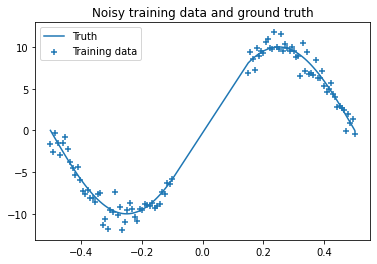

In [6]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 100
noise = 1.0

X1 = np.linspace(-0.5, -0.1, int(train_size/2)).reshape(-1, 1)
X2 = np.linspace(0.15, 0.5, int(train_size/2)).reshape(-1, 1)
X = np.concatenate([X1, X2], axis=0)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend();

In [7]:
test_model = build_model(200)
test_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='MSE')
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = test_model.fit(X, y, 64, epochs=1000, callbacks=[es])

Epoch 1/1000
2/2 [==============================] - 3s 11ms/step - loss: 61.8095
Epoch 2/1000
2/2 [==============================] - 0s 11ms/step - loss: 61.0154
Epoch 3/1000
2/2 [==============================] - 0s 9ms/step - loss: 60.2761
Epoch 4/1000
2/2 [==============================] - 0s 10ms/step - loss: 59.5659
Epoch 5/1000
2/2 [==============================] - 0s 9ms/step - loss: 58.8215
Epoch 6/1000
2/2 [==============================] - 0s 9ms/step - loss: 58.0157
Epoch 7/1000
2/2 [==============================] - 0s 9ms/step - loss: 57.1308
Epoch 8/1000
2/2 [==============================] - 0s 9ms/step - loss: 56.1235
Epoch 9/1000
2/2 [==============================] - 0s 9ms/step - loss: 55.0411
Epoch 10/1000
2/2 [==============================] - 0s 9ms/step - loss: 53.8381
Epoch 11/1000
2/2 [==============================] - 0s 10ms/step - loss: 52.5374
Epoch 12/1000
2/2 [==============================] - 0s 13ms/step - loss: 51.0803
Epoch 13/1000
2/2 [=============

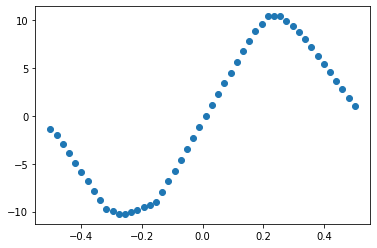

In [8]:
test_input = np.linspace(-0.5,0.5)
test_input = np.array(test_input)
test_output = test_model.predict(test_input)
plt.scatter(test_input, test_output)

100%|██████████| 500/500 [00:52<00:00,  9.53it/s]


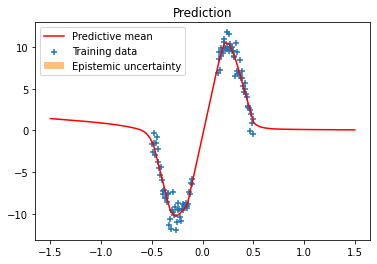

In [9]:
import tqdm
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
y_pred_list = []

for i in tqdm.tqdm(range(500)):
    y_pred = test_model.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(X, y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.legend();

In [10]:
def prune_target_addressor(layer, cutoff):
  weight = layer.weights[0][0]
  weight_temp = copy.deepcopy(weight)
  num_weight = int(weight.shape[-1] * cutoff)
  cutoff_val = np.sort(np.abs(weight_temp))[num_weight]
  mask_target = np.where(np.abs(weight_temp) < cutoff_val)
  mask = np.ones(weight_temp.shape)
  for i in mask_target:
    mask[i] = 0

  mask = np.array(mask, dtype='float32')
  return mask

In [11]:
mask = []

mask.append(prune_target_addressor(test_model.layers[1], 0.5))
mask.append(prune_target_addressor(test_model.layers[2], 0.5))

In [12]:
mask

[array([0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
        0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
        1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0.,
        0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1.,
        0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0.,
        1.,

In [13]:
masked_model = build_sparse_model(200,mask)
masked_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='MSE')
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = masked_model.fit(X, y, 32, epochs=10000, callbacks=[es])

Epoch 1/10000
4/4 [==============================] - 0s 5ms/step - loss: 61.8546
Epoch 2/10000
4/4 [==============================] - 0s 4ms/step - loss: 61.3426
Epoch 3/10000
4/4 [==============================] - 0s 5ms/step - loss: 60.8826
Epoch 4/10000
4/4 [==============================] - 0s 5ms/step - loss: 60.3772
Epoch 5/10000
4/4 [==============================] - 0s 5ms/step - loss: 59.7931
Epoch 6/10000
4/4 [==============================] - 0s 5ms/step - loss: 59.1167
Epoch 7/10000
4/4 [==============================] - 0s 5ms/step - loss: 58.3029
Epoch 8/10000
4/4 [==============================] - 0s 5ms/step - loss: 57.3340
Epoch 9/10000
4/4 [==============================] - 0s 6ms/step - loss: 56.2442
Epoch 10/10000
4/4 [==============================] - 0s 5ms/step - loss: 54.9581
Epoch 11/10000
4/4 [==============================] - 0s 5ms/step - loss: 53.5262
Epoch 12/10000
4/4 [==============================] - 0s 5ms/step - loss: 51.9068
Epoch 13/10000
4/4 [=====

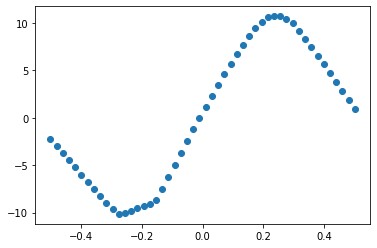

In [14]:
test_input = np.linspace(-0.5,0.5)
test_input = np.array(test_input)
test_output = masked_model.predict(test_input)
plt.scatter(test_input, test_output)

100%|██████████| 500/500 [00:54<00:00,  9.22it/s]


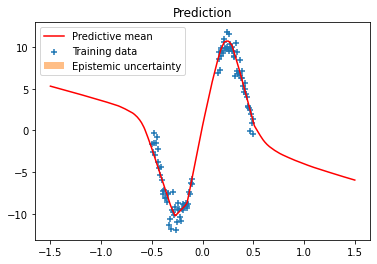

In [15]:
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
y_pred_list = []

for i in tqdm.tqdm(range(500)):
    y_pred = masked_model.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(X, y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.legend();

In [16]:
class maskdeBNNmodel(tf.keras.Model):
  def __init__(self, layer1, layer2, **kwargs):
    super(maskdeBNNmodel, self).__init__(**kwargs)

    self.mask1 = tf.convert_to_tensor(layer1.weight_matrix.numpy())
    self.mask2 = tf.convert_to_tensor(layer2.weight_matrix.numpy())
    one_mtx = np.zeros(shape=layer1.weights[0].shape, dtype='float32')
    self.BNNlayer1 = DenseVariational(layer1, 2)
    self.BNNlayer2 = DenseVariational(layer2, 2)
    self.output_layer = tf.keras.layers.Dense(1)
    self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
    self.regression_loss_tracker = tf.keras.metrics.Mean(
        name="regression_loss"
    )
    self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
  
  @property
  def metrics(self):
      return [
          self.total_loss_tracker,
          self.regression_loss_tracker,
          self.kl_loss_tracker,
      ]
  
  def train_step(self, data):
    x, y = data
    with tf.GradientTape() as tape:
      val1, kl_loss1 = self.BNNlayer1(x)
      val2, kl_loss2 = self.BNNlayer2(val1)
      output = self.output_layer(val2)
      regression_loss = tf.keras.losses.MSE(output, y)
      kl_loss = (kl_loss1 + kl_loss2)/2
      total_loss = kl_loss + regression_loss
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.regression_loss_tracker.update_state(regression_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": self.total_loss_tracker.result(),
        "reconstruction_loss": self.regression_loss_tracker.result(),
        "kl_loss": self.kl_loss_tracker.result(),
    }

  def call(self, inputs):
    val, _ = self.BNNlayer1(inputs)
    val, _ = self.BNNlayer2(val)
    output = self.output_layer(val)
    return val

  def predict(self,inputs):
    val, _ = self.BNNlayer1(inputs)
    val, _ = self.BNNlayer2(val)
    output = self.output_layer(val)
    return output


In [46]:
class DenseVariational(tf.keras.layers.Layer):
    def __init__(self,
                 layer,
                 kl_weight,
                 activation=None,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5, **kwargs):
        self.mask = mask
        self.units = layer.units
        self.kl_weight = kl_weight
        self.activation = tf.keras.activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)
        self.weight_matrix = layer.weights[0].numpy()
        self.bias_matrix = layer.bias.numpy()
        self.mask = layer.weight_matrix.numpy()

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units

    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=tf.keras.initializers.RandomNormal(mean=self.weight_matrix, stddev=self.init_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=tf.keras.initializers.RandomNormal(mean=self.bias_matrix, stddev=self.init_sigma),
                                       trainable=True)
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=tf.keras.initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=tf.keras.initializers.constant(0.0),
                                        trainable=True)
        self.prior_pi_1 = self.add_weight(name='pi1',
                                          shape=(1,),
                                          initializer=tf.keras.initializers.constant(self.prior_pi_1),
                                          constraint = tf.keras.constraints.MinMaxNorm(0,1))
        self.prior_sigma_1 = self.add_weight(name='sig1',
                                             shape=(1,),
                                            initializer=tf.keras.initializers.constant(self.prior_sigma_1),
                                            constraint = tf.keras.constraints.MinMaxNorm(0,1))
        self.prior_sigma_2 = self.add_weight(name='sig2',
                                             shape=(1,),
                                            initializer=tf.keras.initializers.constant(self.prior_sigma_2),
                                            constraint = tf.keras.constraints.MinMaxNorm(0,1))
        self.prior_pi_2 = 1.0 - self.prior_pi_1
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = tf.math.softplus(self.kernel_rho)
        kernel = (self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)) * self.mask

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)
        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) + self.kl_loss(bias, self.bias_mu, bias_sigma))

        return self.activation(K.dot(inputs, kernel) + bias)

    def kl_loss(self, w, mu, sigma):
        variational_dist = tfp.distributions.Normal(mu, sigma)
        klloss = self.kl_weight * tf.reduce_sum(variational_dist.prob(w)* tf.math.log(variational_dist.prob(w) / (self.log_prior_prob(w)+1e-5)))
        return tf.keras.backend.clip(klloss, 1e-23, 1e23)

    def log_prior_prob(self, w):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return self.prior_pi_1 * comp_1_dist.prob(w) + self.prior_pi_2 * comp_2_dist.prob(w)

In [47]:
X.shape

(100, 1)

In [71]:
layer1 = masked_model.layers[1]
layer2 = masked_model.layers[2]

mask1 = tf.convert_to_tensor(layer1.weight_matrix.numpy())
mask2 = tf.convert_to_tensor(layer2.weight_matrix.numpy())

input_length = X.shape[0]
batch_size = 32
KL_weight = batch_size / input_length

input_layer = tf.keras.layers.Input((1,))
BNNlayer1 = DenseVariational(layer1, KL_weight, activation='leaky_relu')(input_layer)
BNNlayer2 = DenseVariational(layer2, KL_weight, activation='leaky_relu')(BNNlayer1)
output_layer = tf.keras.layers.Dense(1)(BNNlayer2)

BNNmodel2 = tf.keras.Model(inputs= input_layer, outputs= output_layer)

In [72]:
def neg_log_likelihood(y_obs, y_pred, sigma=1):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.clip(K.sum(-dist.log_prob(y_obs)), 1e-10, 1e10)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=100)
BNNmodel2.compile(loss=neg_log_likelihood, optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=['mse'])
BNNmodel2.fit(X, y, batch_size=batch_size, epochs=1500, verbose=1);

Epoch 1/1500
4/4 [==============================] - 4s 10ms/step - loss: 1238.9465 - mse: 72.0514
Epoch 2/1500
4/4 [==============================] - 0s 10ms/step - loss: 1404.0107 - mse: 85.0971
Epoch 3/1500
4/4 [==============================] - 0s 10ms/step - loss: 1440.6887 - mse: 84.5090
Epoch 4/1500
4/4 [==============================] - 0s 13ms/step - loss: 672.0110 - mse: 38.3417
Epoch 5/1500
4/4 [==============================] - 0s 11ms/step - loss: 2856.7576 - mse: 174.2610
Epoch 6/1500
4/4 [==============================] - 0s 13ms/step - loss: 1525.0808 - mse: 99.6088
Epoch 7/1500
4/4 [==============================] - 0s 10ms/step - loss: 783.1960 - mse: 45.1441
Epoch 8/1500
4/4 [==============================] - 0s 10ms/step - loss: 2225.4285 - mse: 142.5943
Epoch 9/1500
4/4 [==============================] - 0s 10ms/step - loss: 526.1899 - mse: 28.8952
Epoch 10/1500
4/4 [==============================] - 0s 10ms/step - loss: 1319.6177 - mse: 84.2428
Epoch 11/1500
4/4 [=

100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


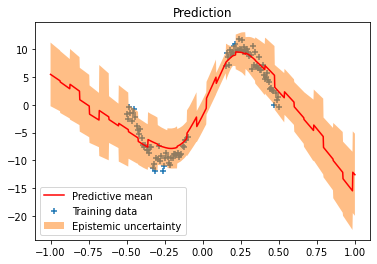

In [70]:

import tqdm

X_test = np.linspace(-1.0, 1.0, 1000).reshape(-1, 1)
y_pred_list = []

for i in tqdm.tqdm(range(10)):
    y_pred = BNNmodel2.predict(X_test)
    y_pred_list.append(y_pred)
    
y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(X, y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.legend();

In [ ]:
test_input = [random.uniform(-2, 12) for i in range(100)]
test_input = np.array(test_input)
test_output = BNNmodel2.predict(test_input)
plt.scatter(test_input, test_output)
plt.xlim(-2, 12)
plt.ylim(-2, 12)

In [ ]:
normal